# Project 

In this jupyter notebook, you have to write your own detector network based on a simplified KITTI dataset for 2D object detection. We already provided an exemplary setup to the problem.

In [0]:
import os
import numpy as np
import cv2
from tqdm.notebook import tqdm
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skimage.transform
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import os
import random
import argparse
import torchvision
import torchvision.transforms as transforms
from PIL import Image

##Mount your Google Drive

In [0]:
#mount drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Load data

In [0]:
store_path = F"drive/My Drive/data/KITTI_2D/Project_detection" #adapt to your file location
x_train = np.load(os.path.join(store_path, "x_train.npy"))
x_test = np.load(os.path.join(store_path, "x_test.npy")) 
y_train = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)

## Plot example 
Here, we plot an example image and the corresponding GT bounding boxes.

float32


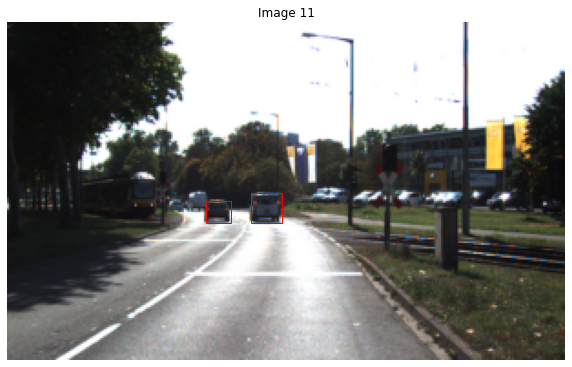

In [0]:
# Colormap for plotted bounding boxes 
cmap = {0: "r", "Pedestrian": "g", "Cyclist": "b", "Van": "yellow", "Truck": "black"}
#we deleted labels other than cars

# Get boxes & classes for specific image
im_number = 11
boxes = y_train[im_number]["boxes"]
classes = y_train[im_number]["classes"]
print(x_train.dtype)
# Plot image
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.imshow(x_train[im_number, ...])
ax.axis("off")
plt.title(f"Image {im_number}")

# Plot colored bounding boxes
for bbox, cls in zip(boxes, classes):
    try:
        cl = cmap[cls]
    except:
        cl = cmap["Misc"]
    # Add rectangle (x,y), width, heigth
    height = bbox[2] - bbox[0]
    width = bbox[3] - bbox[1]
    rect = patches.Rectangle((bbox[1], bbox[0]), width, height, linewidth=1, edgecolor=cl, facecolor="none")
    ax.add_patch(rect)

# Functions needed to calc mAP
It is not necessary to understand them in detail, but nontheless it is important to understand the mAP score.

In [0]:
import six
import itertools
from collections import defaultdict


def voc_eval(pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
             gt_difficults=None, iou_thresh=0.5, use_07_metric=True):
    '''Wrap VOC evaluation for PyTorch.'''
    pred_bboxes = [xy2yx(b).cpu().numpy() for b in pred_bboxes]
    pred_labels = [label.numpy() for label in pred_labels]
    pred_scores = [score.cpu().numpy() for score in pred_scores]
    gt_bboxes = [xy2yx(b).cpu().numpy() for b in gt_bboxes]
    gt_labels = [label.numpy() for label in gt_labels]
    return eval_detection_voc(
               pred_bboxes, pred_labels, pred_scores, gt_bboxes,
               gt_labels, gt_difficults, iou_thresh, use_07_metric)

def xy2yx(boxes):
    '''Convert box (xmin,ymin,xmax,ymax) to (ymin,xmin,ymax,xmax).'''
    c0 = boxes[:,0].clone()
    c2 = boxes[:,2].clone()
    boxes[:,0] = boxes[:,1]
    boxes[:,1] = c0
    boxes[:,2] = boxes[:,3]
    boxes[:,3] = c2
    return boxes

def bbox_iou(bbox_a, bbox_b):
    '''Calculate the Intersection of Unions (IoUs) between bounding boxes.
    Args:
        bbox_a (array): An array whose shape is :math:`(N, 4)`.
            :math:`N` is the number of bounding boxes.
            The dtype should be :obj:`numpy.float32`.
        bbox_b (array): An array similar to :obj:`bbox_a`,
            whose shape is :math:`(K, 4)`.
            The dtype should be :obj:`numpy.float32`.
    Returns:
        array:
        An array whose shape is :math:`(N, K)`. \
        An element at index :math:`(n, k)` contains IoUs between \
        :math:`n` th bounding box in :obj:`bbox_a` and :math:`k` th bounding \
        box in :obj:`bbox_b`.
    '''
    # top left
    tl = np.maximum(bbox_a[:, None, :2], bbox_b[:, :2])
    # bottom right
    br = np.minimum(bbox_a[:, None, 2:], bbox_b[:, 2:])

    area_i = np.prod(br - tl, axis=2) * (tl < br).all(axis=2)
    area_a = np.prod(bbox_a[:, 2:] - bbox_a[:, :2], axis=1)
    area_b = np.prod(bbox_b[:, 2:] - bbox_b[:, :2], axis=1)
    return area_i / (area_a[:, None] + area_b - area_i)

def eval_detection_voc(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function evaluates predicted bounding boxes obtained from a dataset
    which has :math:`N` images by using average precision for each class.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        dict:
        The keys, value-types and the description of the values are listed
        below.
        * **ap** (*numpy.ndarray*): An array of average precisions. \
            The :math:`l`-th value corresponds to the average precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, the corresponding \
            value is set to :obj:`numpy.nan`.
        * **map** (*float*): The average of Average Precisions over classes.
    """

    prec, rec = calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores,
        gt_bboxes, gt_labels, gt_difficults,
        iou_thresh=iou_thresh)

    ap = calc_detection_voc_ap(prec, rec, use_07_metric=use_07_metric)

    return {'ap': ap, 'map': np.nanmean(ap)}


def calc_detection_voc_prec_rec(
        pred_bboxes, pred_labels, pred_scores, gt_bboxes, gt_labels,
        gt_difficults=None,
        iou_thresh=0.5):
    """Calculate precision and recall based on evaluation code of PASCAL VOC.
    This function calculates precision and recall of
    predicted bounding boxes obtained from a dataset which has :math:`N`
    images.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        pred_bboxes (iterable of numpy.ndarray): An iterable of :math:`N`
            sets of bounding boxes.
            Its index corresponds to an index for the base dataset.
            Each element of :obj:`pred_bboxes` is a set of coordinates
            of bounding boxes. This is an array whose shape is :math:`(R, 4)`,
            where :math:`R` corresponds
            to the number of bounding boxes, which may vary among boxes.
            The second axis corresponds to
            :math:`y_{min}, x_{min}, y_{max}, x_{max}` of a bounding box.
        pred_labels (iterable of numpy.ndarray): An iterable of labels.
            Similar to :obj:`pred_bboxes`, its index corresponds to an
            index for the base dataset. Its length is :math:`N`.
        pred_scores (iterable of numpy.ndarray): An iterable of confidence
            scores for predicted bounding boxes. Similar to :obj:`pred_bboxes`,
            its index corresponds to an index for the base dataset.
            Its length is :math:`N`.
        gt_bboxes (iterable of numpy.ndarray): An iterable of ground truth
            bounding boxes
            whose length is :math:`N`. An element of :obj:`gt_bboxes` is a
            bounding box whose shape is :math:`(R, 4)`. Note that the number of
            bounding boxes in each image does not need to be same as the number
            of corresponding predicted boxes.
        gt_labels (iterable of numpy.ndarray): An iterable of ground truth
            labels which are organized similarly to :obj:`gt_bboxes`.
        gt_difficults (iterable of numpy.ndarray): An iterable of boolean
            arrays which is organized similarly to :obj:`gt_bboxes`.
            This tells whether the
            corresponding ground truth bounding box is difficult or not.
            By default, this is :obj:`None`. In that case, this function
            considers all bounding boxes to be not difficult.
        iou_thresh (float): A prediction is correct if its Intersection over
            Union with the ground truth is above this value..
    Returns:
        tuple of two lists:
        This function returns two lists: :obj:`prec` and :obj:`rec`.
        * :obj:`prec`: A list of arrays. :obj:`prec[l]` is precision \
            for class :math:`l`. If class :math:`l` does not exist in \
            either :obj:`pred_labels` or :obj:`gt_labels`, :obj:`prec[l]` is \
            set to :obj:`None`.
        * :obj:`rec`: A list of arrays. :obj:`rec[l]` is recall \
            for class :math:`l`. If class :math:`l` that is not marked as \
            difficult does not exist in \
            :obj:`gt_labels`, :obj:`rec[l]` is \
            set to :obj:`None`.
    """

    pred_bboxes = iter(pred_bboxes)
    pred_labels = iter(pred_labels)
    pred_scores = iter(pred_scores)
    gt_bboxes = iter(gt_bboxes)
    gt_labels = iter(gt_labels)
    if gt_difficults is None:
        gt_difficults = itertools.repeat(None)
    else:
        gt_difficults = iter(gt_difficults)

    n_pos = defaultdict(int)
    score = defaultdict(list)
    match = defaultdict(list)

    for pred_bbox, pred_label, pred_score, gt_bbox, gt_label, gt_difficult in \
        six.moves.zip(
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):

        if gt_difficult is None:
            gt_difficult = np.zeros(gt_bbox.shape[0], dtype=bool)

        for l in np.unique(np.concatenate((pred_label, gt_label)).astype(int)):
            pred_mask_l = pred_label == l
            pred_bbox_l = pred_bbox[pred_mask_l]
            pred_score_l = pred_score[pred_mask_l]
            # sort by score
            order = pred_score_l.argsort()[::-1]
            pred_bbox_l = pred_bbox_l[order]
            pred_score_l = pred_score_l[order]

            gt_mask_l = gt_label == l
            gt_bbox_l = gt_bbox[gt_mask_l]
            gt_difficult_l = gt_difficult[gt_mask_l]

            n_pos[l] += np.logical_not(gt_difficult_l).sum()
            score[l].extend(pred_score_l)

            if len(pred_bbox_l) == 0:
                continue
            if len(gt_bbox_l) == 0:
                match[l].extend((0,) * pred_bbox_l.shape[0])
                continue

            # VOC evaluation follows integer typed bounding boxes.
            pred_bbox_l = pred_bbox_l.copy()
            pred_bbox_l[:, 2:] += 1
            gt_bbox_l = gt_bbox_l.copy()
            gt_bbox_l[:, 2:] += 1

            iou = bbox_iou(pred_bbox_l, gt_bbox_l)
            gt_index = iou.argmax(axis=1)
            # set -1 if there is no matching ground truth
            gt_index[iou.max(axis=1) < iou_thresh] = -1
            del iou

            selec = np.zeros(gt_bbox_l.shape[0], dtype=bool)
            for gt_idx in gt_index:
                if gt_idx >= 0:
                    if gt_difficult_l[gt_idx]:
                        match[l].append(-1)
                    else:
                        if not selec[gt_idx]:
                            match[l].append(1)
                        else:
                            match[l].append(0)
                    selec[gt_idx] = True
                else:
                    match[l].append(0)

    for iter_ in (
            pred_bboxes, pred_labels, pred_scores,
            gt_bboxes, gt_labels, gt_difficults):
        if next(iter_, None) is not None:
            raise ValueError('Length of input iterables need to be same.')

    n_fg_class = max(n_pos.keys()) + 1
    prec = [None] * n_fg_class
    rec = [None] * n_fg_class

    for l in n_pos.keys():
        score_l = np.array(score[l])
        match_l = np.array(match[l], dtype=np.int8)

        order = score_l.argsort()[::-1]
        match_l = match_l[order]

        tp = np.cumsum(match_l == 1)
        fp = np.cumsum(match_l == 0)

        # If an element of fp + tp is 0,
        # the corresponding element of prec[l] is nan.
        prec[l] = tp / (fp + tp)
        # If n_pos[l] is 0, rec[l] is None.
        if n_pos[l] > 0:
            rec[l] = tp / n_pos[l]

    return prec, rec


def calc_detection_voc_ap(prec, rec, use_07_metric=False):
    """Calculate average precisions based on evaluation code of PASCAL VOC.
    This function calculates average precisions
    from given precisions and recalls.
    The code is based on the evaluation code used in PASCAL VOC Challenge.
    Args:
        prec (list of numpy.array): A list of arrays.
            :obj:`prec[l]` indicates precision for class :math:`l`.
            If :obj:`prec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        rec (list of numpy.array): A list of arrays.
            :obj:`rec[l]` indicates recall for class :math:`l`.
            If :obj:`rec[l]` is :obj:`None`, this function returns
            :obj:`numpy.nan` for class :math:`l`.
        use_07_metric (bool): Whether to use PASCAL VOC 2007 evaluation metric
            for calculating average precision. The default value is
            :obj:`False`.
    Returns:
        ~numpy.ndarray:
        This function returns an array of average precisions.
        The :math:`l`-th value corresponds to the average precision
        for class :math:`l`. If :obj:`prec[l]` or :obj:`rec[l]` is
        :obj:`None`, the corresponding value is set to :obj:`numpy.nan`.
    """

    n_fg_class = len(prec)
    ap = np.empty(n_fg_class)
    for l in six.moves.range(n_fg_class):
        if prec[l] is None or rec[l] is None:
            ap[l] = np.nan
            continue

        if use_07_metric:
            # 11 point metric
            ap[l] = 0
            for t in np.arange(0., 1.1, 0.1):
                if np.sum(rec[l] >= t) == 0:
                    p = 0
                else:
                    p = np.max(np.nan_to_num(prec[l])[rec[l] >= t])
                ap[l] += p / 11
        else:
            # correct AP calculation
            # first append sentinel values at the end
            mpre = np.concatenate(([0], np.nan_to_num(prec[l]), [0]))
            mrec = np.concatenate(([0], rec[l], [1]))

            mpre = np.maximum.accumulate(mpre[::-1])[::-1]

            # to calculate area under PR curve, look for points
            # where X axis (recall) changes value
            i = np.where(mrec[1:] != mrec[:-1])[0]

            # and sum (\Delta recall) * prec
            ap[l] = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

# Exemplary mAP calculation
The example below shows you, how the mAP is calculated for (fake) predictions on the training set.
A similar calculation will be used to predict the mean average precision of your algorithm on the test set.
Please store your predictions containing three dictionaries for the boxes, labels and scores per test image (similar to "pred_example.npy").

In [0]:
store_path = F"drive/My Drive/data/KITTI_2D/Project_detection" #adapt to your file location

#read prediction
pred_test = np.load(os.path.join(store_path, "pred_example.npy"), allow_pickle=True)
pred_boxes = [torch.Tensor(x["boxes"]) for x in pred_test]  # List with n_test elements [n_boxes, 4]
pred_classes = [torch.Tensor(x["classes"]) for x in pred_test] # List with n_test elements [n_boxes]
pred_scores = [torch.Tensor(x["scores"]) for x in pred_test] # List with n_test elements [n_boxes]

#read gt
gt = np.load(os.path.join(store_path, "y_train.npy"), allow_pickle=True)
gt_boxes = [torch.Tensor(x["boxes"]) for x in gt[1:3]]  # List with n_test elements [n_boxes, 4]
gt_labels = [torch.Tensor(x["classes"]) for x in gt[1:3]] # List with n_test elements [n_boxes]

## Calc mAP
print("Calculating mAP")
meanAP = voc_eval(pred_boxes, pred_classes, pred_scores, gt_boxes, gt_labels)["map"]
print('Mean Average Precision of best network: %.5f' % (meanAP))

Calculating mAP
Mean Average Precision of best network: 0.90909
